In [1]:
# %matplotlib widget

In [2]:
import os
import glob
from natsort import natsorted
from tqdm import tqdm
import itertools

import pandas as pd
import numpy as np
from tabulate import tabulate

from nilearn import image
import nibabel as nib

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from scipy.stats import pearsonr, zscore, ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
bids_dir = '/Users/emcmaho7/Desktop/SI_fMRI'
derivatives_dir = f'{bids_dir}/derivatives'
fmriprep_dir = f'{derivatives_dir}/fmriprep'
nilearn_dir = f'{derivatives_dir}/nilearn'
reliability_dir = f'{derivatives_dir}/reliability'
mask_dir = f'{derivatives_dir}/ROI_masks'
em_dir = f'{derivatives_dir}/encoding_models'

In [4]:
rois = ['EVC', 'MT', 'EBA', 'PPA', 'TOS', 'RSC', 'LOC',  'FFA', 'OFA', 'faceSTS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']
roi_names = ['EVC', 'MT', 'EBA', 'PPA', 'OPA', 'RSC', 'LOC',  'FFA', 'OFA', 'faceSTS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']

In [5]:
from nilearn import surface, image, datasets, plotting
fsaverage = datasets.fetch_surf_fsaverage()

/Applications/anaconda3/envs/nilearn/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# Loading

## Zmaps

In [6]:
fname = f'{nilearn_dir}/sub-all_task-SIdyads_desc-train_stat-z_statmap.npy'
z_maps = np.load(fname)
n_subjs = z_maps.shape[0]
tot_voxels = z_maps.shape[1]

### AlexNet

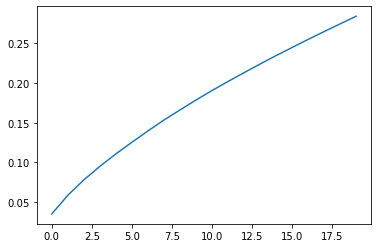

In [7]:
layer = 2
alexnet = zscore(np.load(f'alexnet_conv{layer}_avgframe.npy'), axis=-1)

pca = PCA(svd_solver='full', n_components=20)
alexnet = pca.fit_transform(alexnet.T)

fig, ax = plt.subplots()
plt.plot(pca.explained_variance_ratio_.cumsum())

### Optical flow

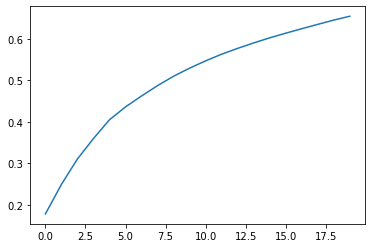

In [8]:
of = zscore(np.load(f'of_adelsonbergen.npy'), axis=0)
pca = PCA(svd_solver='full', n_components=20)
of = pca.fit_transform(of)

fig, ax = plt.subplots()
plt.plot(pca.explained_variance_ratio_.cumsum())

### Control model

In [9]:
control_model = np.concatenate((alexnet, of), axis=-1)

In [10]:
control_model = zscore(control_model, axis=1)
control_model.shape

(200, 40)

## Features

In [11]:
bdf = pd.read_csv('annotations/annotations.csv')
train = pd.read_csv('annotations/train.csv')
bdf = bdf.merge(train)
bdf.sort_values(by=['video_name'], inplace=True)

In [12]:
feature_categories = ['visual', 'visual', 'visual', 'visual', 'visual',
                     'social detection', 'social detection', 
                     'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation']
features = bdf.columns.to_list()
features.remove('video_name')

In [13]:
model = []
for feature in features:
    arr = zscore(bdf[feature].to_numpy())
    arr = np.expand_dims(arr, axis=0)
    if type(model) == list:
        model = arr.copy()
    else:
        model = np.append(model, arr, axis=0) 
feature_arr = model.T

# Encoding models

## Functions

### Activation

In [14]:
def get_activation(z_map, path=None, threshold=0.279):
    """
        z_map: the map of the brain to be masked
        path: the path the the file to be loaded and used as a mask
                if no path is provided, z_map is returned unchanged
        threshold: the critical value to threshold the mask based on
    """
    #activity in ROI
    if path is not None: 
        mask = np.load(path)

        #Make into a binary numpy array
        mask_arr = np.zeros_like(mask, dtype='bool')
        mask_arr[mask > threshold] = 1
    else:
        mask_arr = np.ones((z_map.shape[:-1]), dtype='bool')  
    
    #Get the activation
    activation = z_map[mask_arr, :]
        
    #Remove nan values (these are voxels that do not vary across the different videos)
    inds = ~np.any(np.isnan(activation), axis=1)
    return activation[inds, ...], mask_arr, inds

## Run Models

In [15]:
sid_ = 2
sid = str(sid_+1).zfill(2)
path = f'{reliability_dir}/sub-{sid}/sub-{sid}_desc-test_stat-rho_statmap.npy'
X, mask, X_inds = get_activation(z_maps[sid_, ...], path)

#remove nan values
rm_nan = np.invert(np.any(np.isnan(X), axis=1))
X = X[rm_nan, ...]

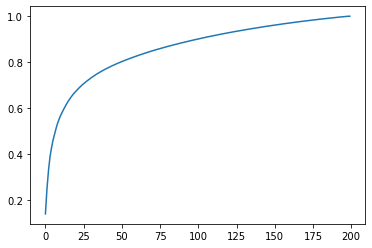

In [16]:
pca = PCA(svd_solver='full')
pca.fit(X)
fig, ax = plt.subplots()
plt.plot(pca.explained_variance_ratio_.cumsum())

eigenvalues = pca.explained_variance_
n_components = np.sum(eigenvalues > 1)
pca = PCA(svd_solver='full', n_components=n_components)
X_new = pca.fit_transform(X)
PCs = np.argmax(X_new, axis=1)

In [17]:
loadings = pca.components_ @ control_model
pcs = [f'PC{i+1}' for i in range(n_components)]
inds = [f'AlexNet{i+1}' if i < 20 else f'OF{i+1}' for i in range(40)]
loading_matrix = pd.DataFrame(loadings.T, columns=pcs, index=inds)

for col in pcs: 
    print(tabulate(loading_matrix.sort_values(by=col, ascending=False),
                   headers='keys', tablefmt='psql'))

+-----------+-------------+------------+------------+------------+-------------+------------+
|           |         PC1 |        PC2 |        PC3 |        PC4 |         PC5 |        PC6 |
|-----------+-------------+------------+------------+------------+-------------+------------|
| AlexNet2  |  8.30467    |  8.57479   | -7.33123   |  1.05932   | -10.5717    |  3.82235   |
| AlexNet17 |  1.48068    | -2.96771   | -1.62784   | -1.79543   |  -0.628248  |  1.65826   |
| OF26      |  1.44661    |  0.694138  |  1.25736   | -0.366514  |  -2.25334   |  1.33405   |
| AlexNet4  |  1.42634    | -1.87583   |  3.41853   | -1.2631    |   2.16734   | -2.85923   |
| AlexNet14 |  1.41383    |  0.865691  |  2.21752   |  1.0476    |   0.0217134 | -1.85291   |
| AlexNet7  |  1.31923    |  0.0117124 | -3.07365   |  0.939527  |  -2.41732   |  2.61193   |
| OF24      |  0.984088   | -0.250189  |  1.74278   |  0.239987  |   1.52761   | -2.06032   |
| AlexNet15 |  0.27806    | -0.194088  |  1.78734   | -0.743

In [26]:
pca.components_.shape

(6, 200)

In [18]:
loadings = pca.components_ @ feature_arr
pcs = [f'PC{i+1}' for i in range(n_components)]
loading_matrix = pd.DataFrame(loadings.T, columns=pcs, index=features)

for col in pcs: 
    print(tabulate(loading_matrix.sort_values(by=col, ascending=False),
                   headers='keys', tablefmt='psql'))

+----------------+-----------+-----------+-----------+------------+-----------+-----------+
|                |       PC1 |       PC2 |       PC3 |        PC4 |       PC5 |       PC6 |
|----------------+-----------+-----------+-----------+------------+-----------+-----------|
| dominance      |  3.68075  |  1.77289  | -1.29892  |  2.89827   |  0.450492 |  0.204779 |
| intimacy       |  3.14178  |  2.60386  | -0.177618 |  2.6417    | -3.3873   |  0.544615 |
| arousal        |  2.89835  |  1.54849  |  5.43371  | -2.1721    |  0.293436 |  1.17051  |
| indoor         |  2.35824  |  3.99686  | -1.91411  |  1.23247   | -3.25743  |  1.09945  |
| joint action   |  2.13271  |  1.4664   |  2.055    | -0.536091  | -1.68952  | -0.302009 |
| facingness     |  1.66658  |  2.52108  | -3.19392  |  0.072186  | -0.355518 |  1.63138  |
| valence        | -0.125669 |  1.32218  |  2.52088  |  1.05875   | -2.15431  | -2.35194  |
| transitivity   | -0.18761  | -4.56325  | -0.944744 |  0.615275  |  1.25645  | 

In [19]:
PC_map = np.zeros_like(mask, dtype='int')
inds = np.where(mask)
t = np.zeros_like(inds).squeeze()
t[X_inds] = PCs
PC_map[inds] = t + 1

In [20]:
def arr2surf(sid, arr, surf=fsaverage.pial_right):
    maps = glob.glob(f'{nilearn_dir}/sub-{sid}/*desc-test*.nii.gz')
    im = image.load_img(maps[0])
    arr = arr.reshape(im.shape[:-1])
    arr = nib.Nifti1Image(arr, im.affine)
        
    return surface.vol_to_surf(arr, surf, interpolation='nearest')

In [21]:
def vol2surf(sid, mask, surf=fsaverage.pial_right):
    #vol to surf
    surf = arr2surf(sid, np.zeros_like(mask, dtype='int'),
                   surf=fsaverage.pial_right)
    for i in range(1, n_components+1):
        cur = np.zeros_like(PC_map)
        cur[PC_map == i] = 1
        cur = arr2surf(sid, cur)
        surf[np.where(cur)] = i*0.1
    return surf

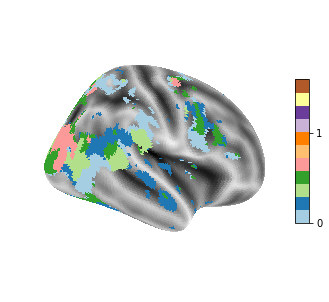

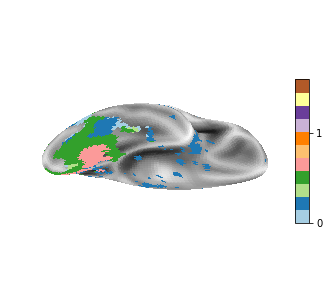

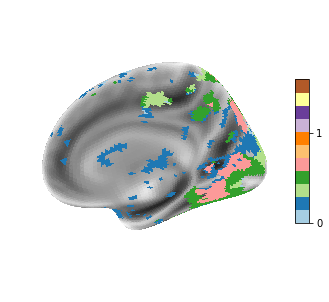

In [23]:
surf = vol2surf(sid, mask, surf=fsaverage.pial_right)

#Plotting
cmap=sns.color_palette("Paired", as_cmap=True)
plotting.plot_surf_roi(fsaverage.infl_right, surf,
                   bg_map=fsaverage.sulc_right, threshold=0.1,
                   symmetric_cmap=False, view='lateral',
                      hemi='right', colorbar=True, cmap=cmap)
plotting.plot_surf_roi(fsaverage.infl_right, surf,
                   bg_map=fsaverage.sulc_right, threshold=0.1,
                   symmetric_cmap=False, view='ventral',
                      hemi='right', colorbar=True, cmap=cmap)
plotting.plot_surf_roi(fsaverage.infl_right, surf,
                   bg_map=fsaverage.sulc_right, threshold=0.1,
                   symmetric_cmap=False, view='medial',
                      hemi='right', colorbar=True, cmap=cmap)
plt.show()

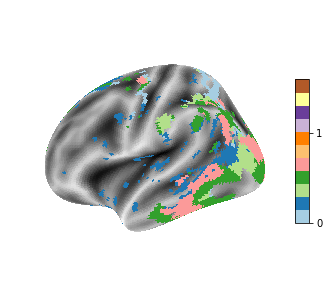

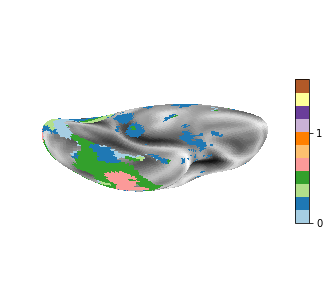

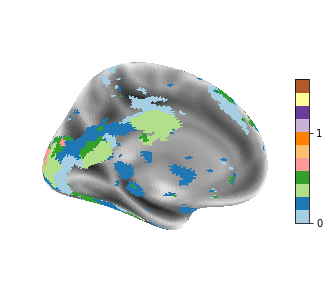

In [24]:
surf = vol2surf(sid, mask, surf=fsaverage.pial_left)

#Plotting
cmap=sns.color_palette("Paired", as_cmap=True)
plotting.plot_surf_roi(fsaverage.infl_left, surf,
                   bg_map=fsaverage.sulc_left, threshold=0.1,
                   symmetric_cmap=False, view='lateral',
                      hemi='left', colorbar=True, cmap=cmap)
plotting.plot_surf_roi(fsaverage.infl_left, surf,
                   bg_map=fsaverage.sulc_left, threshold=.1,
                   symmetric_cmap=False, view='ventral',
                      hemi='left', colorbar=True, cmap=cmap)
plotting.plot_surf_roi(fsaverage.infl_left, surf,
                   bg_map=fsaverage.sulc_left, threshold=0.1,
                   symmetric_cmap=False, view='medial',
                      hemi='left', colorbar=True, cmap=cmap)
plt.show()

In [25]:
n_components

6